In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

In [2]:
amcX = pd.read_csv('amcDF-q2.csv')
amcX = amcX.loc[:, amcX.columns != 'date']
amcX = amcX.loc[:, amcX.columns != 'Unnamed: 0']
amcX = amcX.loc[:, amcX.columns != 'daychange']
amcX = amcX.loc[:, amcX.columns != 'anger']
amcX = amcX.loc[:, amcX.columns != 'disgust']
amcX = amcX.loc[:, amcX.columns != 'fear']
amcX = amcX.loc[:, amcX.columns != 'joy']
amcX = amcX.loc[:, amcX.columns != 'sadness']
amcX = amcX.loc[:, amcX.columns != 'surprise']
amcX = amcX.loc[:, amcX.columns != 'connectivity']
amcX = amcX.loc[:, amcX.columns != 'avgdeg']

amcX = amcX.head(70)
amcX

,size,edges,diameter,clustering,volume
0,26,19,6,0.000000,29873800
1,40,31,4,0.000000,28148300
2,51,37,4,0.000000,67363300
3,15,9,2,0.000000,26150500
4,15,8,2,0.000000,39553300
...,...,...,...,...,...
65,1528,3371,10,0.000418,33408700
66,1541,3152,11,0.000392,29254600
67,1841,3871,10,0.000504,51269800
68,1554,3558,10,0.000852,44049100


<Axes: >

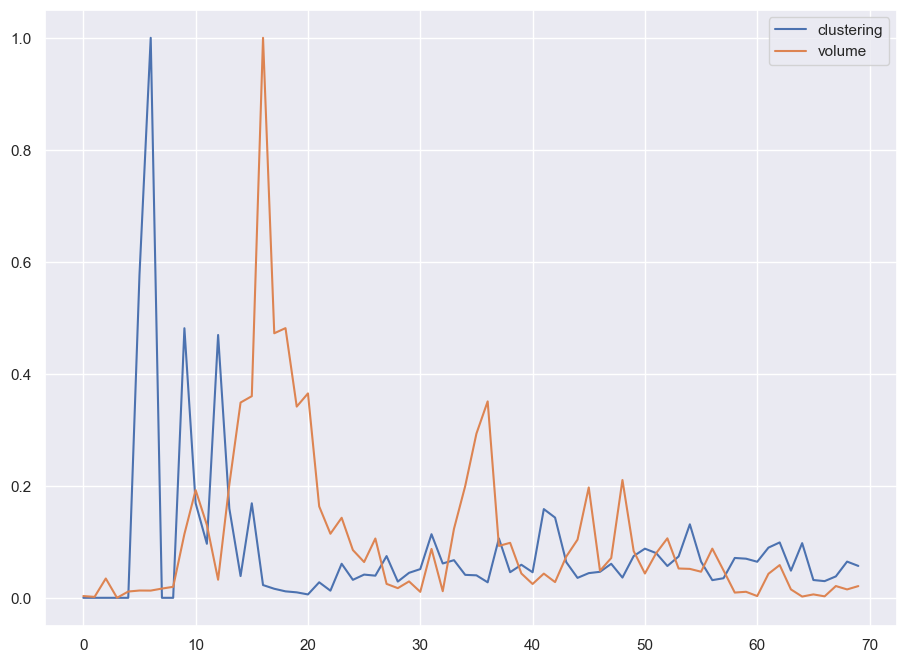

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
sns.set(rc={'figure.figsize':(11,8)})

amcXs = scaler.fit_transform(amcX)
amcXs = pd.DataFrame(amcXs,columns=['size','edges','diameter','clustering','volume'])
amcXs[['clustering','volume']].plot()

In [4]:
for metric in amcXs.columns:
    result = adfuller(amcXs[[metric]])
    print('A-DF of metric',metric,'has p-value of',result[1])
    print()

A-DF of metric size has p-value of 0.00014569819133998356

A-DF of metric edges has p-value of 0.0001530666977458152

A-DF of metric diameter has p-value of 0.009570661433927066

A-DF of metric clustering has p-value of 1.963530933191857e-05

A-DF of metric volume has p-value of 0.11076150855013489



In [16]:
#build the VAR model
model = VAR(amcXs)
print(model.select_order(5))

amc_model = model.fit(4)

amc_model.summary()

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 4, BIC -> 2, FPE -> 4, HQIC ->  2>


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 11, Oct, 2023
Time:                     10:12:20
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -26.7025
Nobs:                     66.0000    HQIC:                  -28.8095
Log likelihood:           632.890    FPE:                8.71065e-14
AIC:                     -30.1861    Det(Omega_mle):     2.18864e-14
--------------------------------------------------------------------
Results for equation size
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.015649         0.038723            0.404           0.686
L1.size              10.756491         3.504555            3.069           0.002
L1.edges            -10.049665         3.468609           -2.

Text(0, 0.5, 'Volume (0,1)')

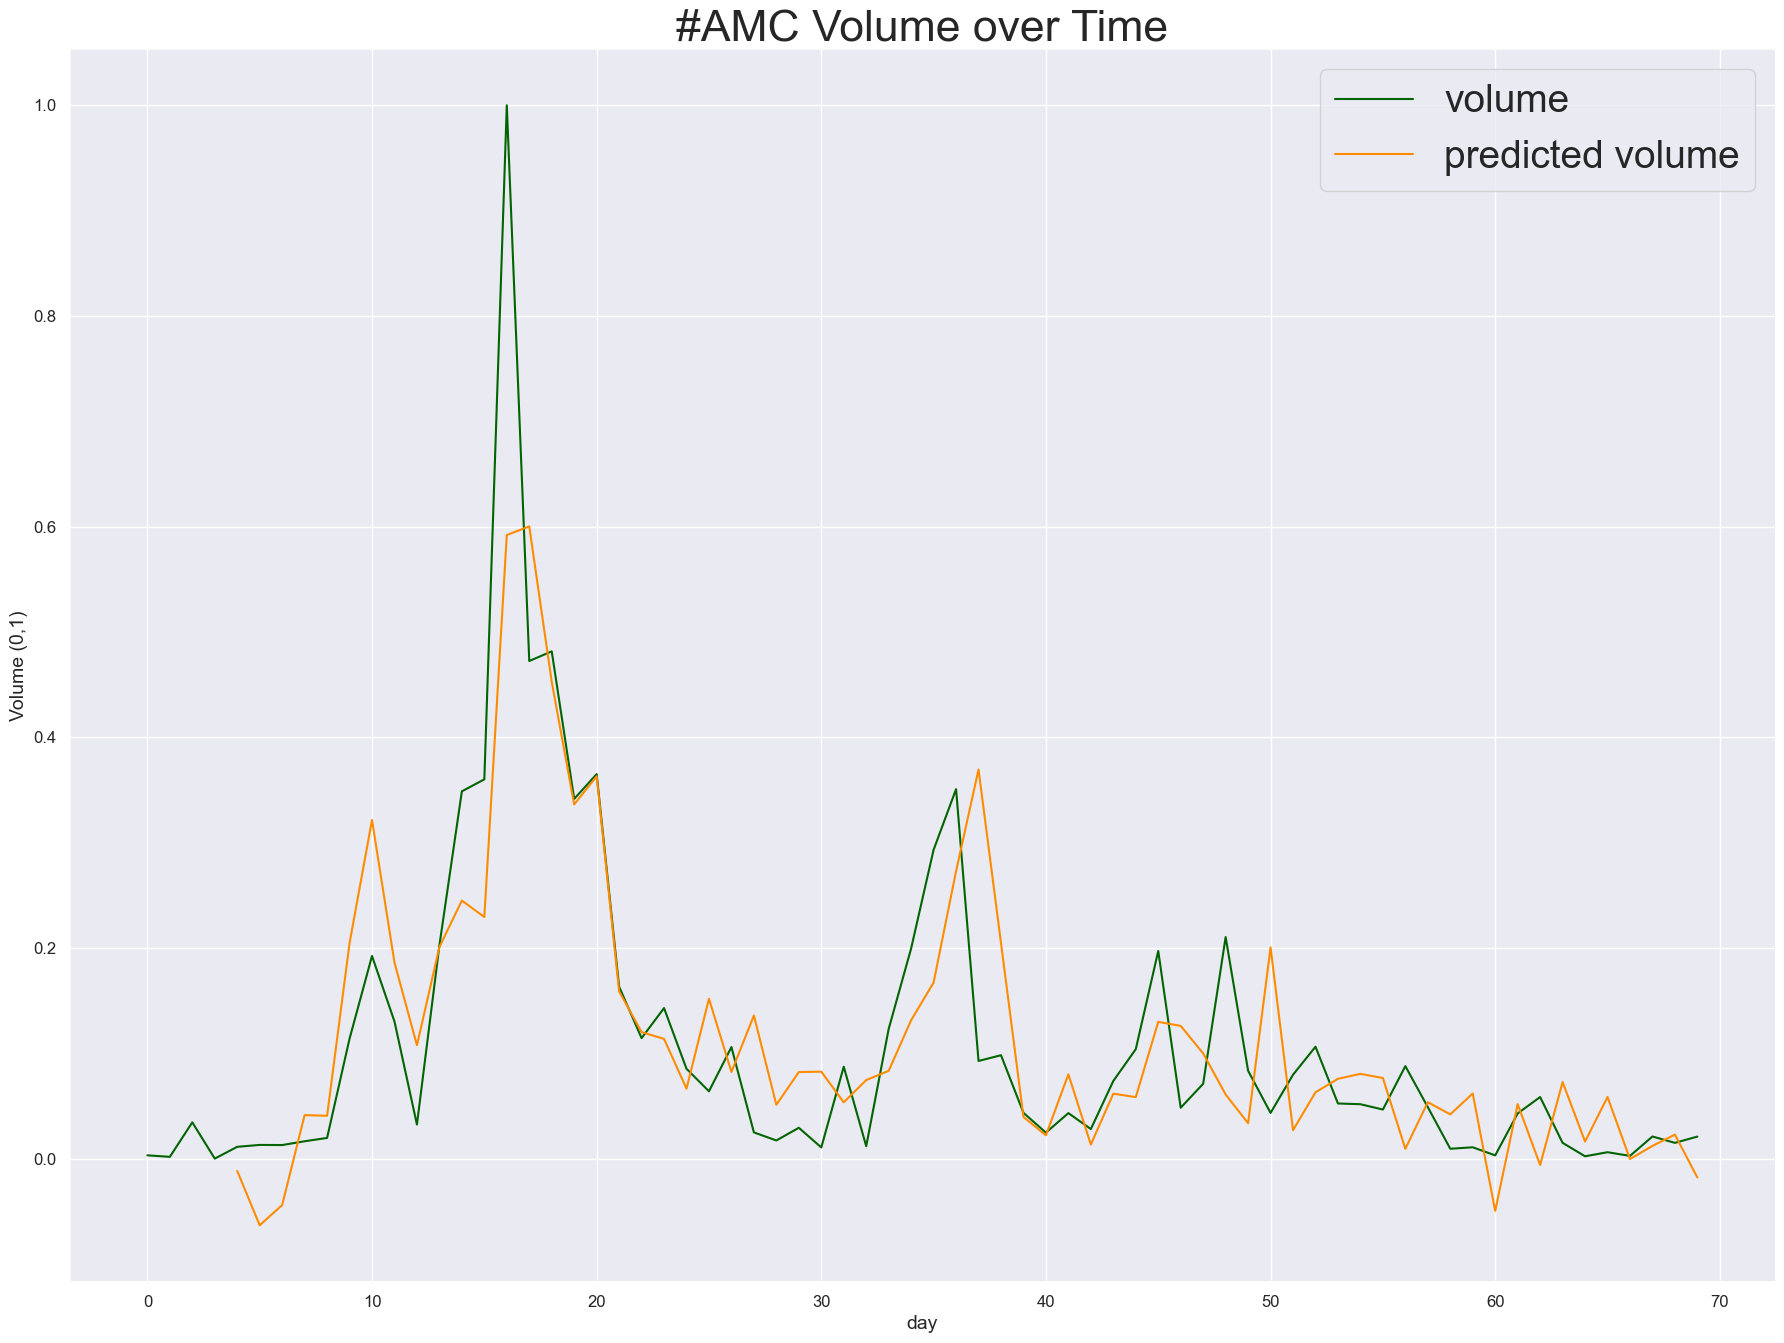

In [6]:
#forecast and plot

sns.set(rc={'figure.figsize':(22,16)})

plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

amcXs[['volume']].plot(color='darkgreen')
plt.plot(amc_model.fittedvalues['volume'],color='darkorange',label='predicted volume')
plt.legend(fontsize='28')
plt.title('#AMC Volume over Time',fontsize=32)
plt.xlabel('day')
plt.ylabel('Volume (0,1)')

In [7]:
#test for causality
print(amc_model.test_causality(4,0))
print(amc_model.test_causality(4,1))
print(amc_model.test_causality(4,2))
print(amc_model.test_causality(4,3))
print(amc_model.test_causality(4,4))

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: size does not Granger-cause volume: fail to reject at 5% significance level. Test statistic: 0.306, critical value: 2.412>, p-value: 0.874>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: edges does not Granger-cause volume: fail to reject at 5% significance level. Test statistic: 0.369, critical value: 2.412>, p-value: 0.831>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: diameter does not Granger-cause volume: fail to reject at 5% significance level. Test statistic: 1.642, critical value: 2.412>, p-value: 0.165>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: clustering does not Granger-cause volume: reject at 5% significance level. Test statistic: 3.387, critical value: 2.412>, p-value: 0.010>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: volume does 

In [8]:
print('AMC',mean_absolute_error(amcXs[['volume']][4:],amc_model.fittedvalues['volume']))

AMC 0.05896625111512358
